In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


import seaborn as sns
import matplotlib.pyplot as plt

import string
import warnings
import missingno
warnings.filterwarnings('ignore')

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)


# Y = total_cost


In [2]:
print(df_train.shape)
print(df_train.dtypes)

(4809, 23)
ID                        object
country                   object
age_group                 object
travel_with               object
total_female             float64
total_male               float64
purpose                   object
main_activity             object
info_source               object
tour_arrangement          object
package_transport_int     object
package_accomodation      object
package_food              object
package_transport_tz      object
package_sightseeing       object
package_guided_tour       object
package_insurance         object
night_mainland           float64
night_zanzibar           float64
payment_mode              object
first_trip_tz             object
most_impressing           object
total_cost               float64
dtype: object


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

<Axes: >

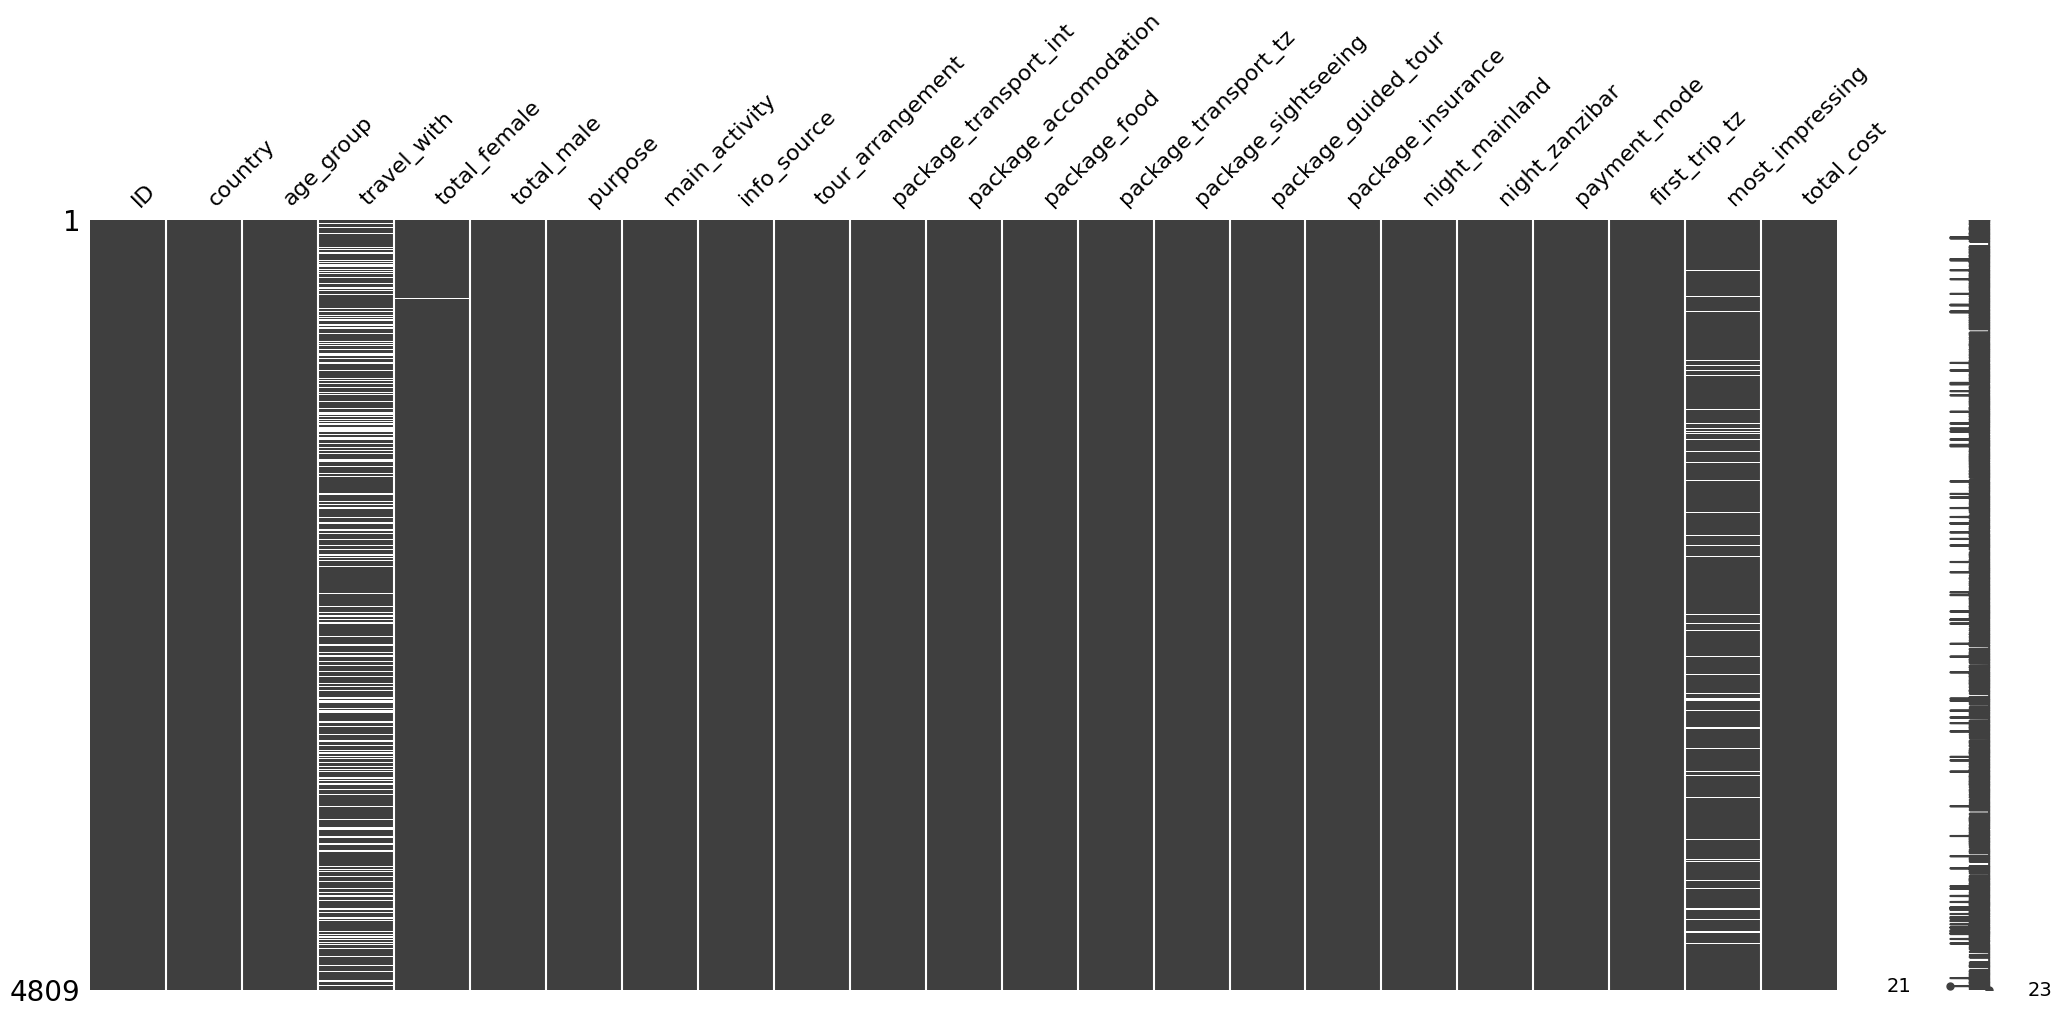

In [4]:
missingno.matrix(df_train)

In [5]:
cat_cols = df_train.select_dtypes(include='category').columns
for col in cat_cols:
    df_train[col] = df_train[col].str.strip().str.lower()

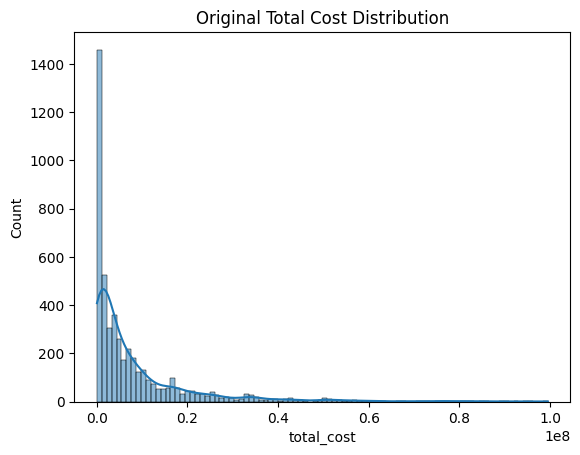

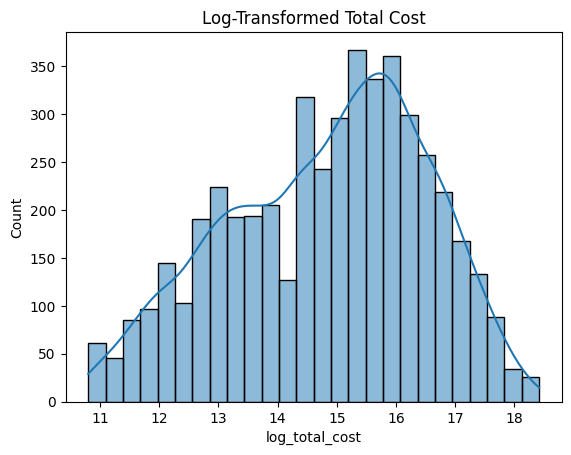

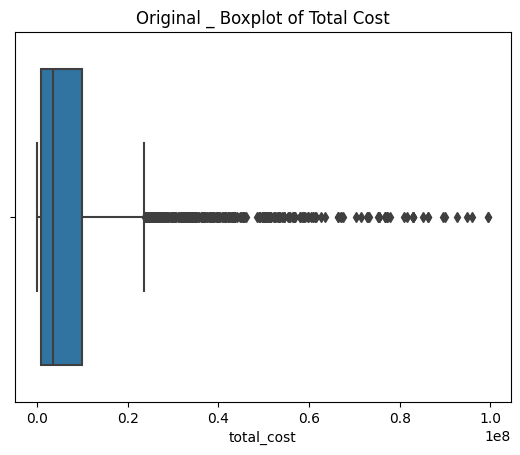

In [6]:
sns.histplot(df_train['total_cost'], kde=True)
plt.title("Original Total Cost Distribution")
plt.show()

df_train['log_total_cost'] = np.log1p(df_train['total_cost'])

sns.histplot(df_train['log_total_cost'], kde=True)
plt.title("Log-Transformed Total Cost")
plt.show()

sns.boxplot(x=df_train['total_cost'])
plt.title("Original _ Boxplot of Total Cost")
plt.show()

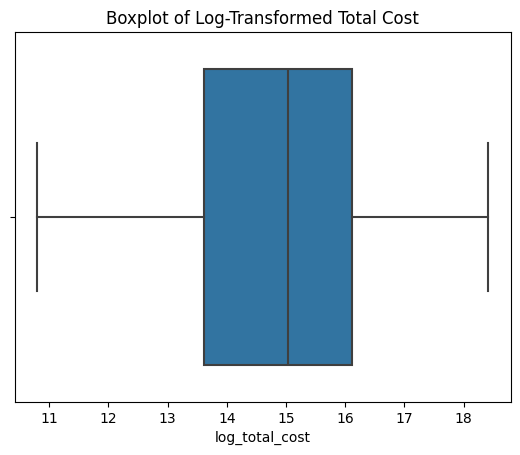

In [7]:
# after log
sns.boxplot(x=df_train['log_total_cost'])
plt.title("Boxplot of Log-Transformed Total Cost")
plt.show()

In [8]:
# df_train.head(5)  
# new feature ---> log_total_cost

In [9]:
df_train['total_female'] = df_train['total_female'].fillna(0) #total_female 또는 total_male에 값이 비어 있으면(NaN) → 0으로 바꾼다
df_train['total_male'] = df_train['total_male'].fillna(0)

In [10]:
df_train['travel_with'] = df_train['travel_with'].fillna('alone')

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in cat_cols:
    if col == 'ID':
        continue
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_train, x=col, y='total_cost')
    plt.xticks(rotation=45)
    plt.title(f'Total Cost by {col}')
    plt.tight_layout()
    plt.show()


In [12]:
cat_cols = df_train.select_dtypes(include='object').columns.tolist()

cat_cols = [col for col in cat_cols if col != 'ID']

median_cost_by_category = {}

for col in cat_cols:
    median_values = df_train.groupby(col)['total_cost'].median().sort_values(ascending=False)
    median_cost_by_category[col] = median_values

for col, medians in median_cost_by_category.items():
    print(f"\n▶ {col} by total_cost_Ranking by median:")
    print(medians)



▶ country by total_cost_Ranking by median:
country
DOMINICA      33150000.0
COSTARICA     27183000.0
SLOVENIA      19062372.0
TUNISIA       15746250.0
COLOMBIA      15580500.0
                 ...    
MADAGASCAR      194550.0
YEMEN           192812.5
URUGUAY         165750.0
BURUNDI         162500.0
LESOTHO         160000.0
Name: total_cost, Length: 105, dtype: float64

▶ age_group by total_cost_Ranking by median:
age_group
65+      12845625.0
45-64     5834400.0
1-24      2602275.0
25-44     2486250.0
Name: total_cost, dtype: float64

▶ travel_with by total_cost_Ranking by median:
travel_with
Spouse and Children    14720606.00
Spouse                  8623454.00
Children                5687662.50
Friends/Relatives       4972500.00
alone                   1585721.75
Alone                   1491750.00
Name: total_cost, dtype: float64

▶ purpose by total_cost_Ranking by median:
purpose
Leisure and Holidays              7293000.0
Volunteering                      2652000.0
Meetings and Co

In [13]:
print(df_train['log_total_cost'].describe())

count    4809.000000
mean       14.826733
std         1.681619
min        10.799596
25%        13.607472
50%        15.038661
75%        16.112581
max        18.415999
Name: log_total_cost, dtype: float64


# Evaluation metrics 

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [15]:
baseline_mean = df_train['log_total_cost'].mean()
print(f"Baseline Mean Total Cost: {baseline_mean:,.0f} TZS(log)")

y_true = df_train['log_total_cost']
y_pred = [baseline_mean] * len(y_true)

baseline_rmse = rmse(y_true, y_pred)
print(f"Baseline RMSE: {baseline_rmse:,.0f} TZS(log)")

baseline_mean_origin = np.expm1(15 - 2)
print("baseline_mean_origin:", baseline_mean_origin)


Baseline Mean Total Cost: 15 TZS(log)
Baseline RMSE: 2 TZS(log)
baseline_mean_origin: 442412.3920089205


# BOX PLOT

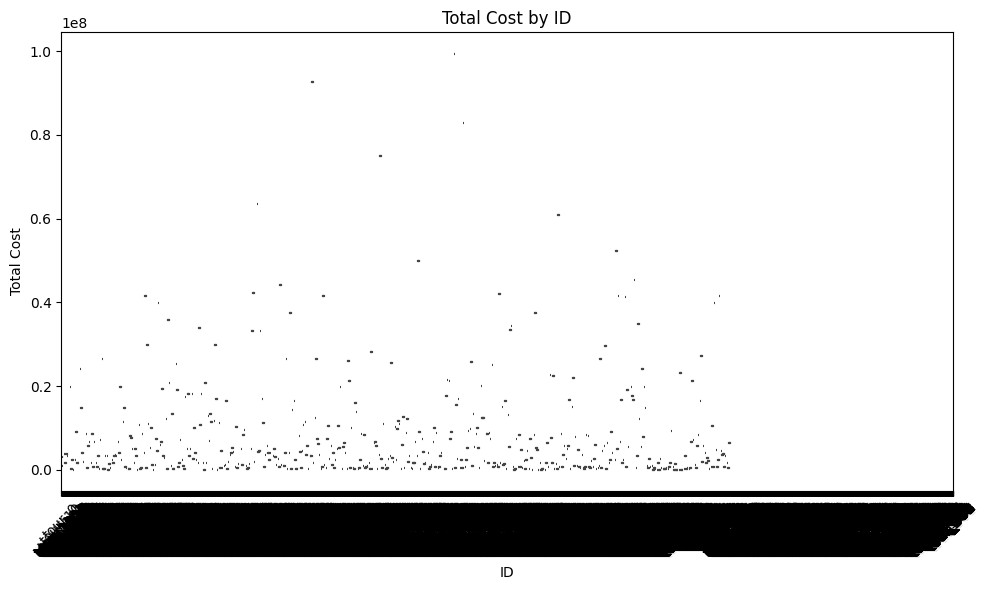

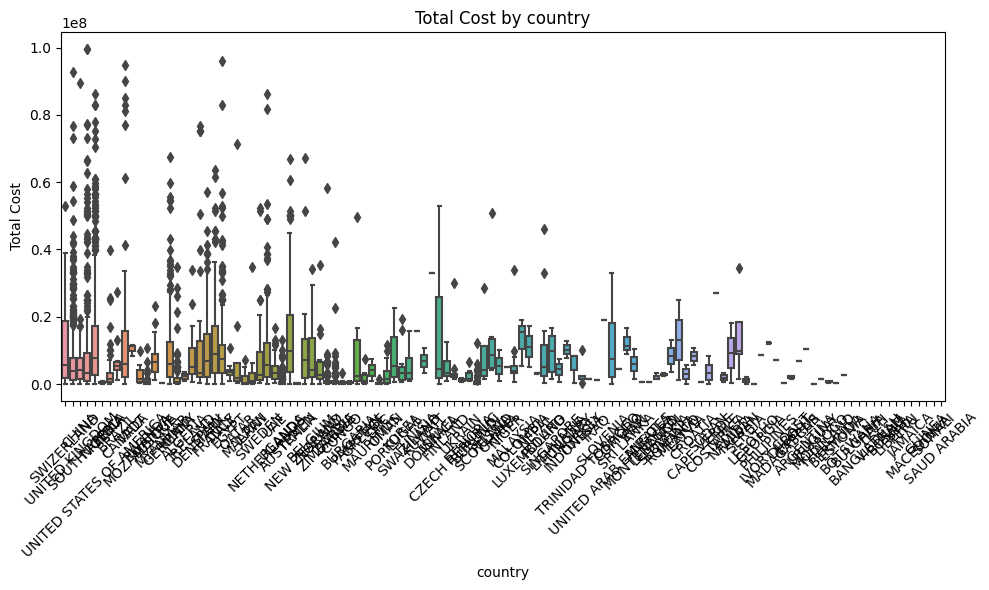

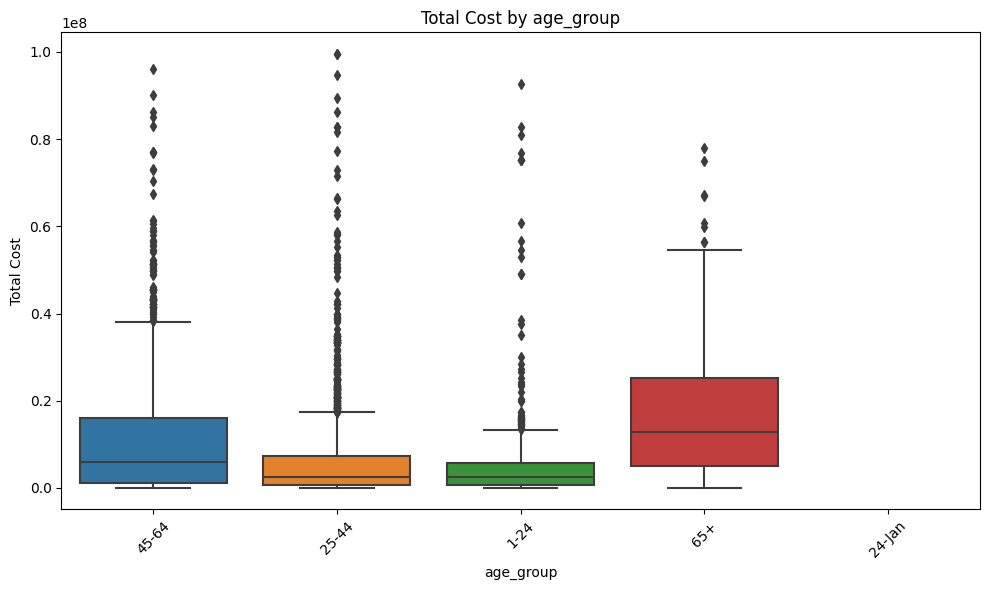

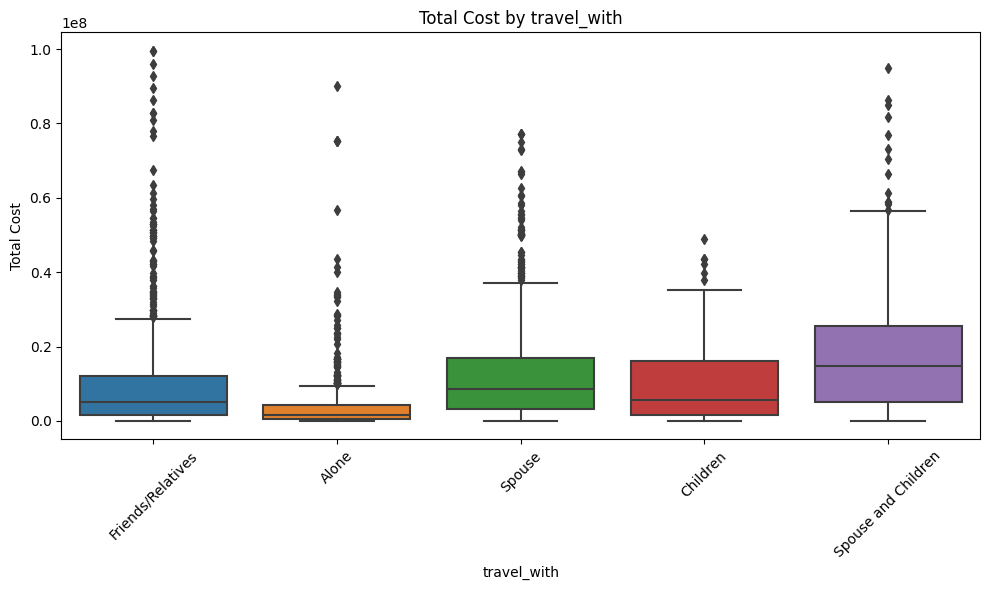

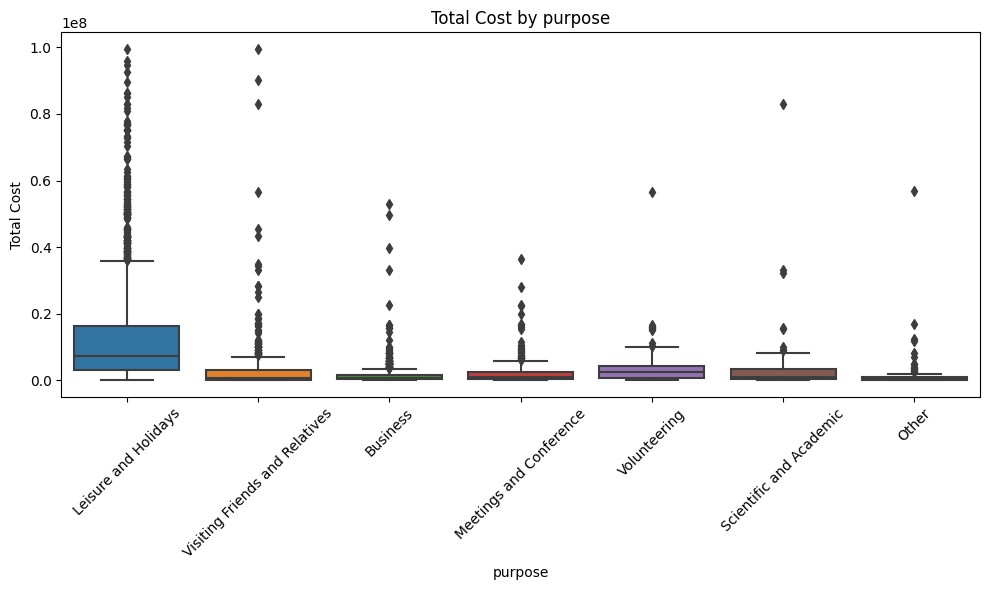

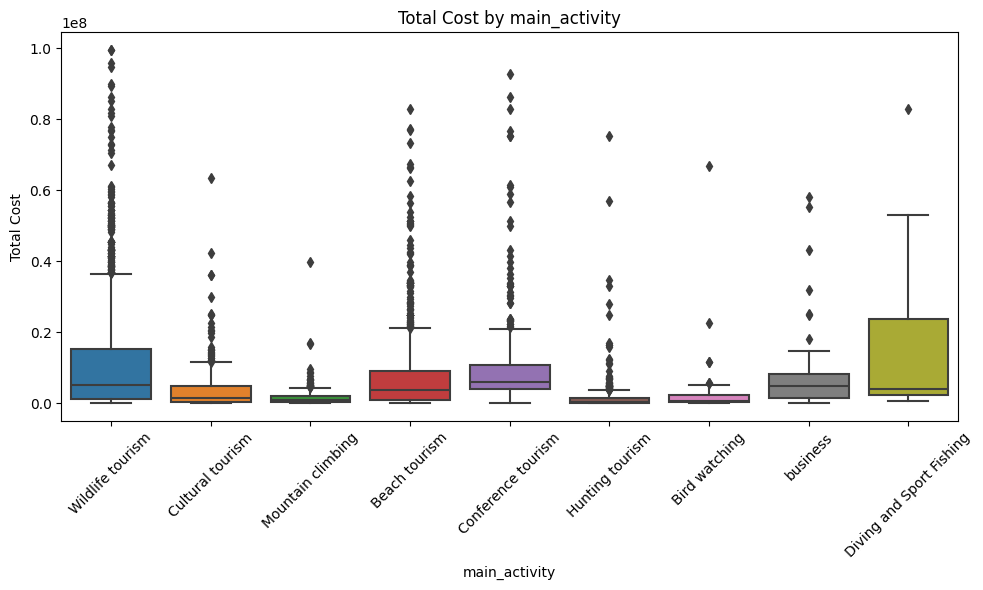

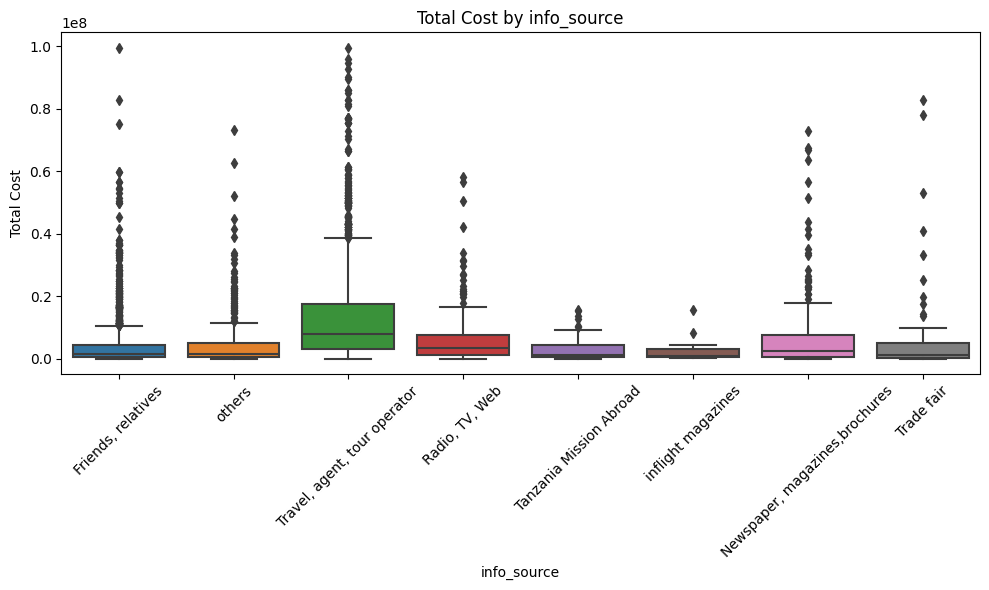

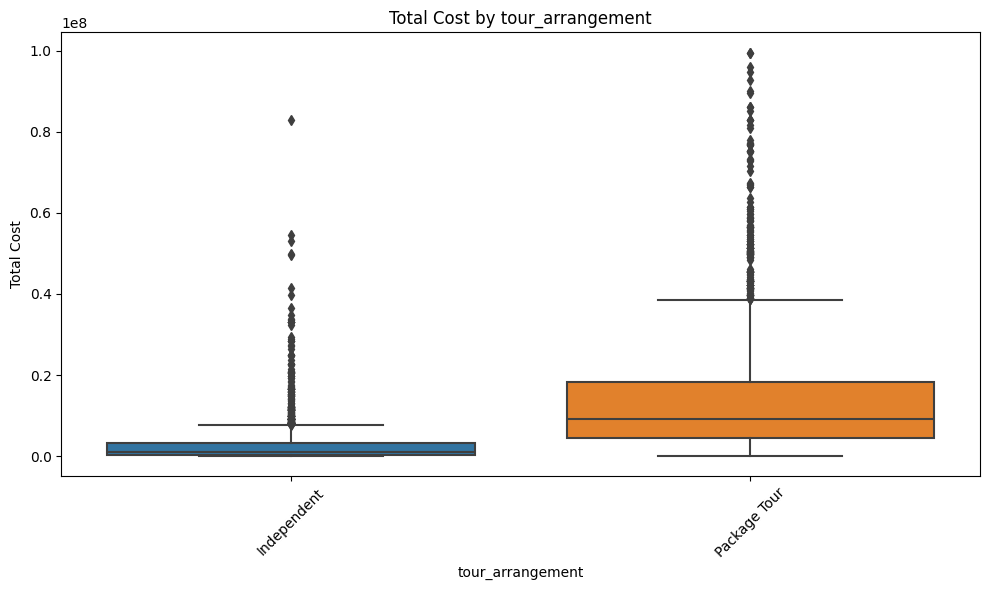

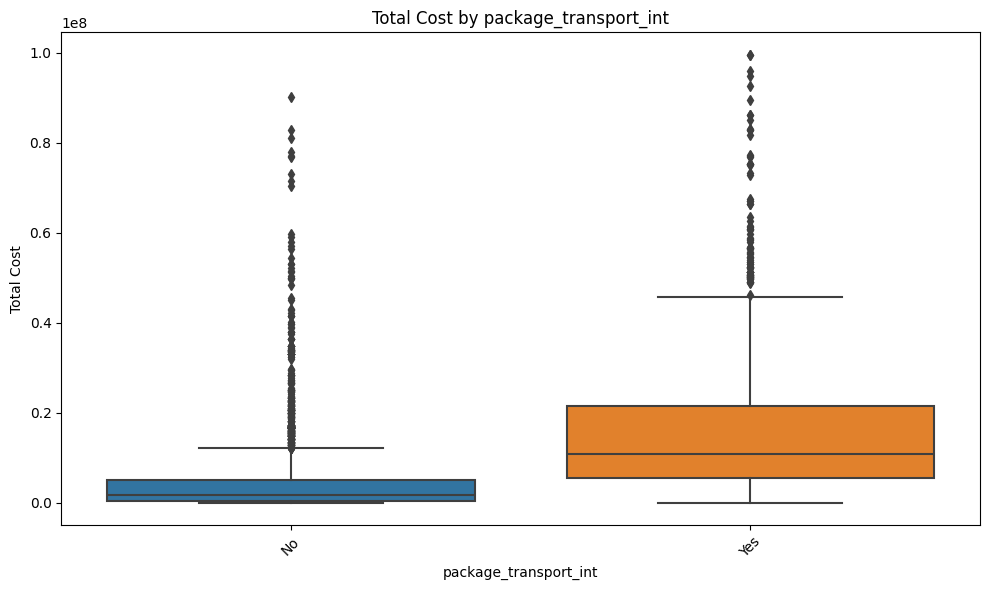

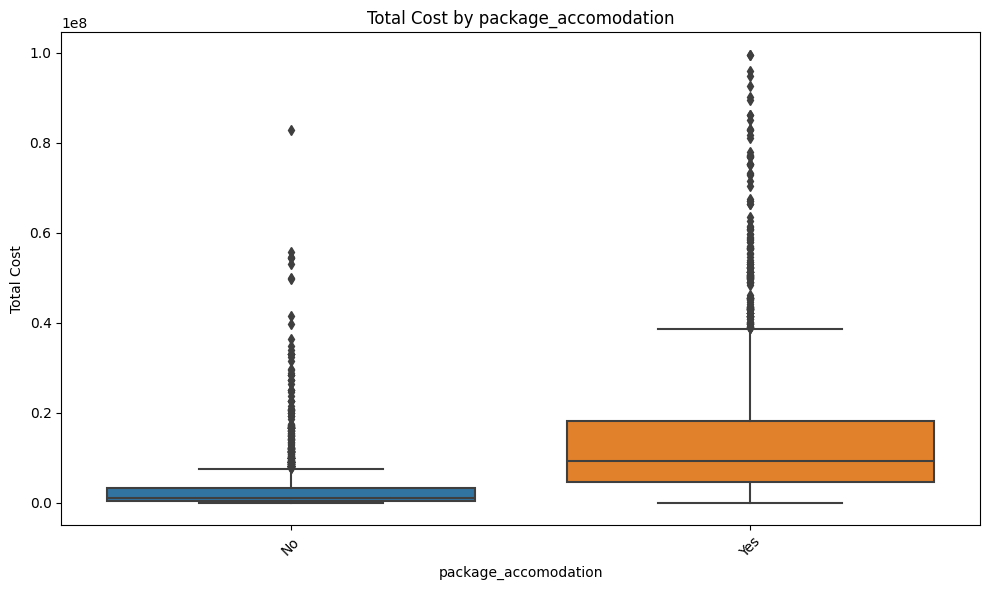

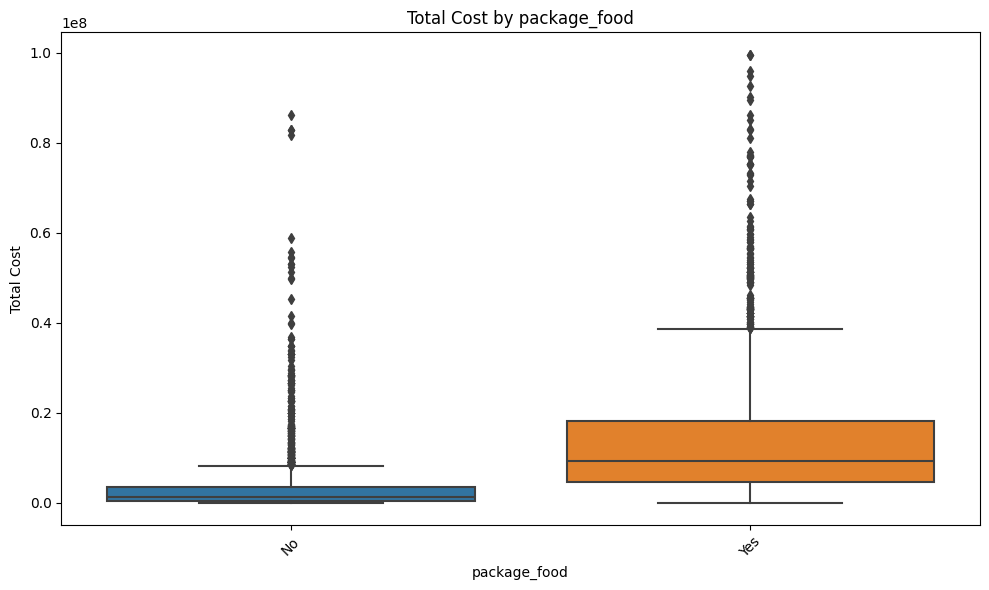

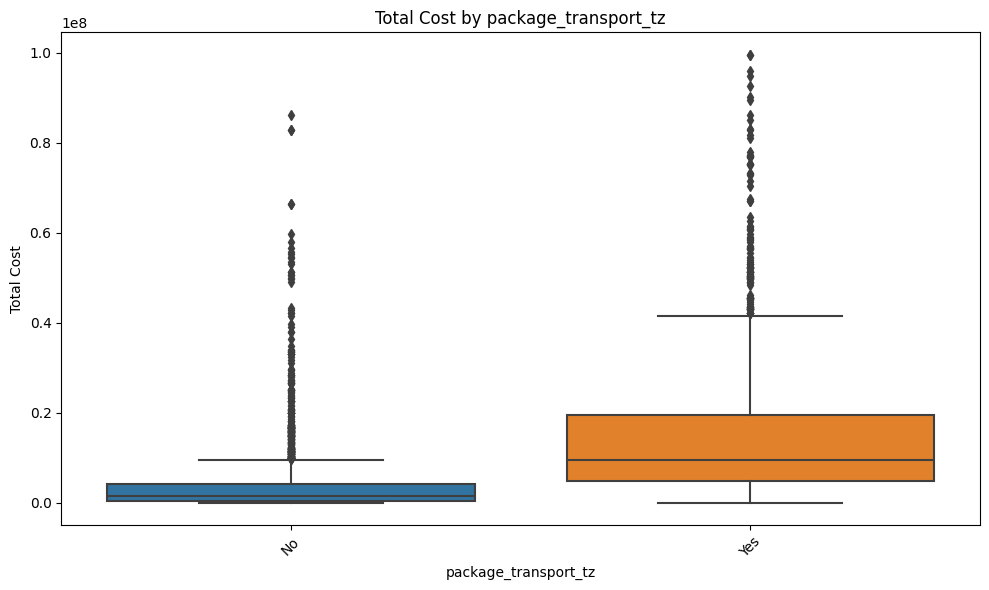

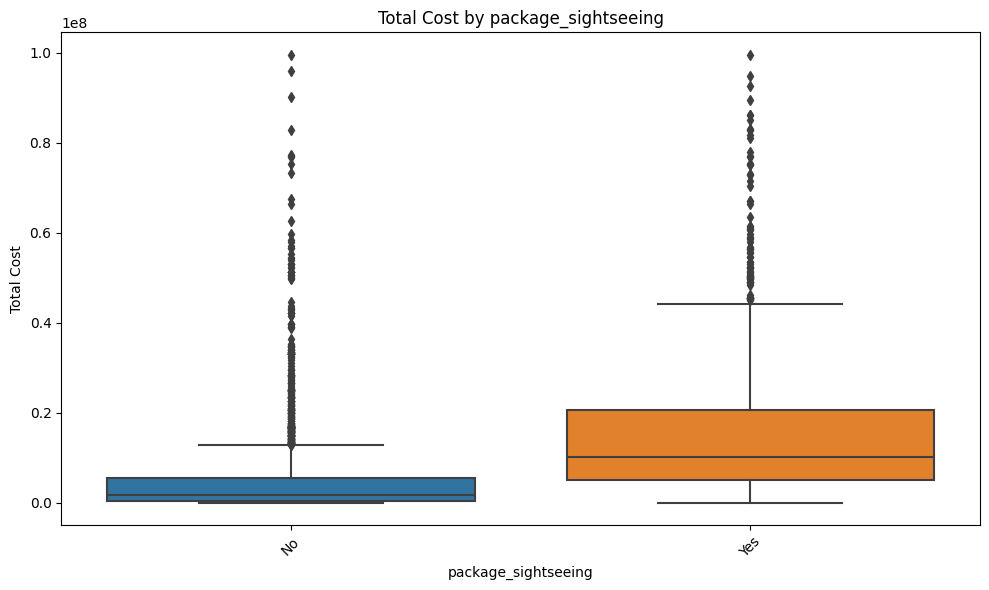

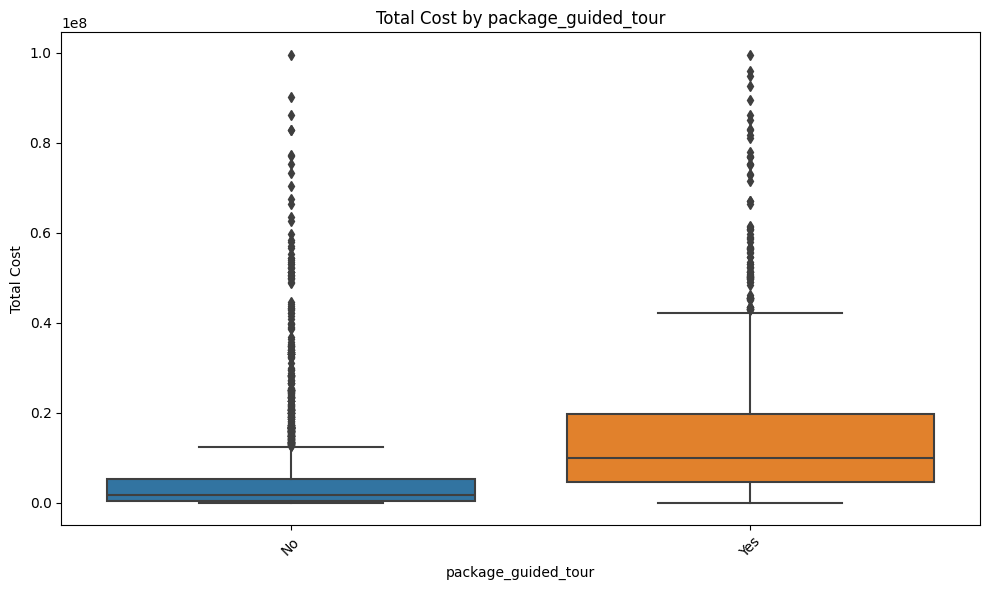

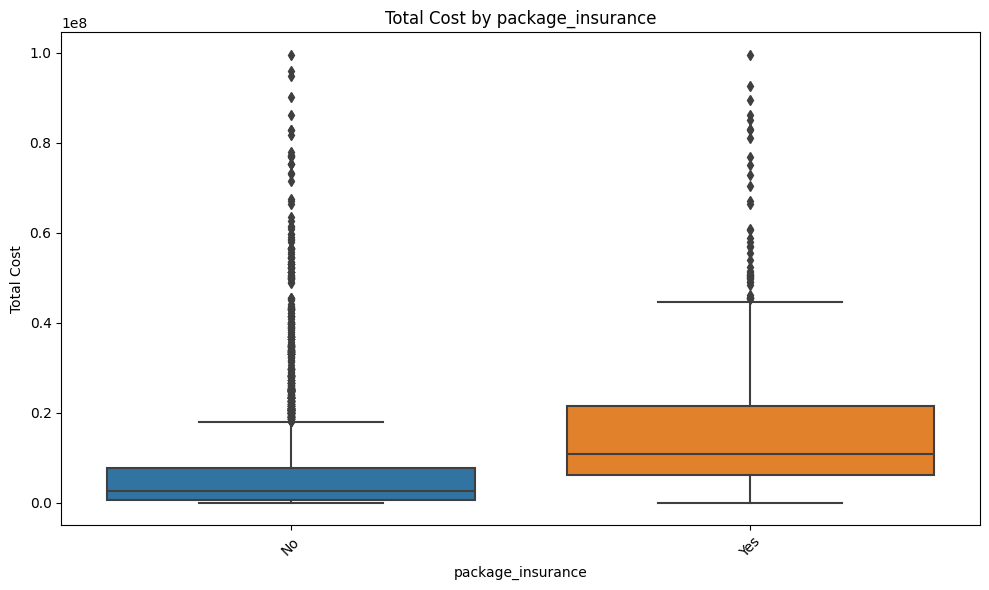

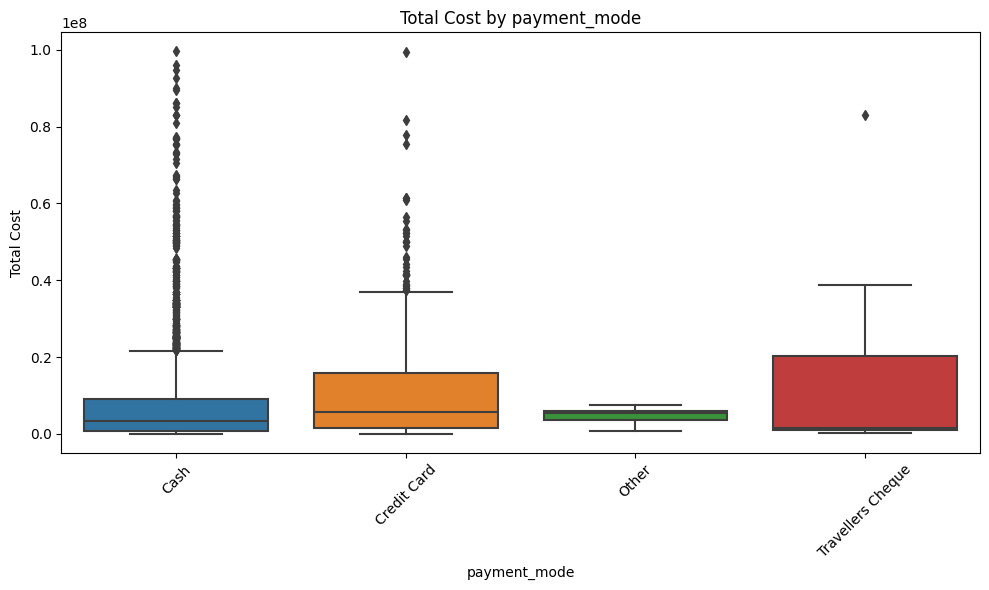

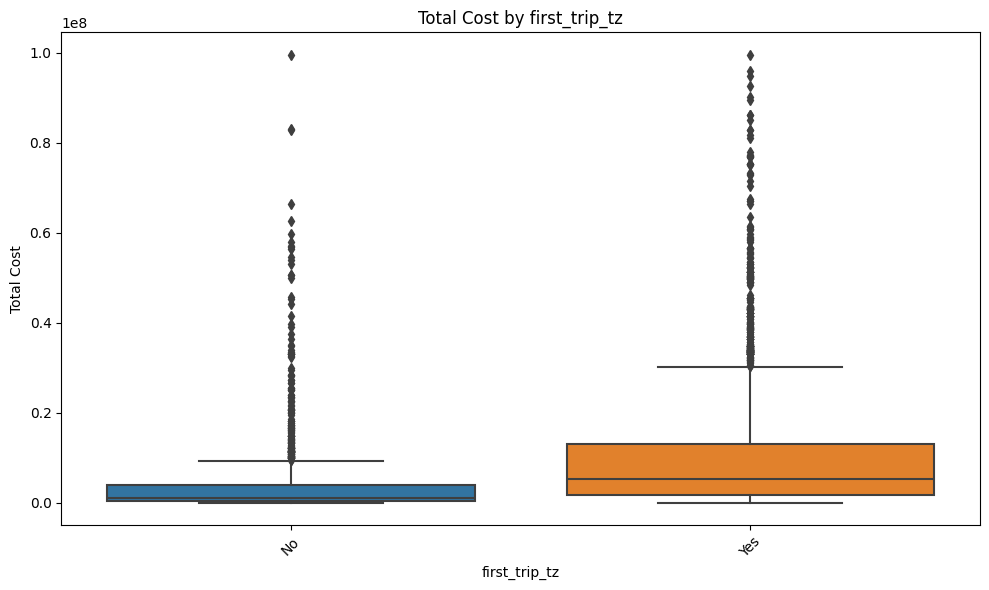

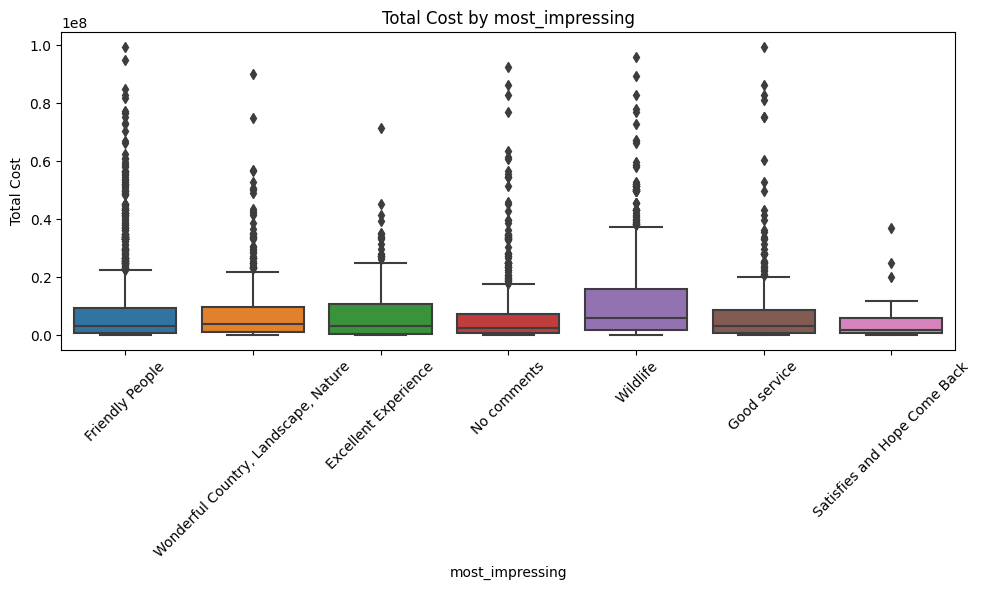

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


cat_cols = df_all.select_dtypes(include=['object', 'category']).columns.tolist()


target = 'total_cost'

for col in cat_cols:
    if col == target: 
        continue
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_all, x=col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'Total Cost by {col}')
    plt.xlabel(col)
    plt.ylabel('Total Cost')
    plt.tight_layout()
    plt.show()
